In [2]:
sc

<SparkContext master=local[*] appName=PySparkShell>

## Importing Necessary Libraries

In [3]:
# Standard Libraries
import time
from queue import Queue
from threading import Thread

# Data Processing Libraries
import numpy as np
import pandas as pd

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning and Utilities
import tflite_runtime.interpreter as tflite
from pyspark.sql import SparkSession
from sklearn.metrics import confusion_matrix
import warnings

warnings.filterwarnings('ignore')

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Initializing Spark Session

In [4]:
spark = SparkSession.builder.appName("AnomalyDetection").getOrCreate()

## Loading the Data

In [5]:
# Read the file for streaming as a Dataframe
df = spark.read.csv("stream_data/test_50_records_v3.csv", header=True, inferSchema=True)
numpy_array = df.toPandas()

23/10/05 22:21:58 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


## Loading TensorFlow Lite Model

In [6]:
# Load the .tflite model
interpreter = tflite.Interpreter(model_path="new_best_model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


## Stream Data and Predictive Model Handlers

In [7]:
# Function simulating the incoming stream of data
def stream_data(df, q, sleep_time=0.1):
    """Simulate streaming by sending samples to a queue with delay."""
    for index, row in df.iterrows():
        q.put(row)
        time.sleep(sleep_time)

# Function to handle data and make predictions
def handle_data(q, y_true_list, y_pred_list):
    """Handle incoming data, make predictions and update true and predicted labels list."""
    while True:
        data_row = q.get()
        if data_row is None:  # A sentinel value to end the loop
            break

        # Extract the features and true label from the row
        sample = data_row.drop(labels=["attack"]).values
        y_true = data_row["attack"]

        # Predict using the model
        sample = np.expand_dims(sample, axis=0).astype(input_details[0]['dtype'])
        interpreter.set_tensor(input_details[0]['index'], sample)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])[0]
        
        predicted_label = 1 if output_data[0] >= 0.5 else 0
        
        y_true_list.append(y_true)
        y_pred_list.append(predicted_label)
        q.task_done()

## Simulation of Streaming and Prediction

In [8]:
# Lists to store the true and predicted labels
y_true_list = []
y_pred_list = []

# Queue to hold incoming samples
q = Queue(maxsize=100)

# Start the threads  
producer = Thread(target=stream_data, args=(numpy_array, q))
consumer = Thread(target=handle_data, args=(q, y_true_list, y_pred_list))

producer.start()
consumer.start()

# Join the threads
producer.join()
q.put(None)  # This will signal the consumer to finish up
consumer.join()

# Calculate the accuracy
accuracy = np.mean(np.array(y_pred_list) == np.array(y_true_list))
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 100.00%


## Visualization: Confusion Matrix

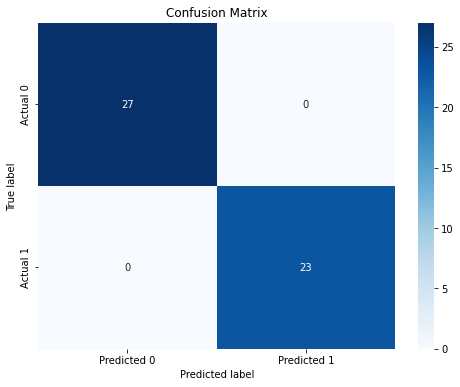

In [9]:
# Compute the confusion matrix
cm = confusion_matrix(y_true_list, y_pred_list)

# Plotting the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()